# Config

In [1]:
from parameters import get_parameters

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import shap

/home/Documents/Dengue/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# department = "Antioquia"
# spatial_effects = ["Cordoba", "Choco", "Caldas", "Santander", "Bolivar"]
department = "Valle"
spatial_effects = ["Choco", "Risaralda", "Quindio", "Cauca", "Tolima"]
lags = range(52, 60) # range(1, 52*3+3)
validation_year = 2019

In [3]:
params = get_parameters()
source_conformed = params["source_conformed"]

PROJECT_ROOT = Path().resolve().parent
print(f"Project root: {PROJECT_ROOT}")

Project root: /home/Documents/Dengue


In [4]:
df = pd.read_pickle(f"{PROJECT_ROOT}/{source_conformed}/{department.lower()}.pkl")
df_cases = df[["CASES"]]
df_temperature = df[["TEMPERATURE"]]
df_pressure = df[["PRESSURE"]]

In [5]:
df_spatial = df_cases.copy()

for i in spatial_effects:
    df_tmp = pd.read_pickle(f"{PROJECT_ROOT}/{source_conformed}/{i.lower()}.pkl")
    df_tmp = df_tmp[["CASES"]]
    df_spatial = df_spatial.merge(df_tmp, on="DATE", how="left", suffixes=("", f"_{i}"))
df_spatial = df_spatial.drop(columns=["CASES"], errors="ignore")

In [6]:
df_seasonality = df_cases.copy()

week = df_seasonality.index.isocalendar().week.astype(int)
week = week.clip(upper=52)
df_seasonality["Seasonality1"] = np.sin(2 * np.pi * week / 52)
df_seasonality["Seasonality2"] = np.cos(2 * np.pi * week / 52)

df_seasonality = df_seasonality.drop(columns=["CASES"], errors="ignore")

In [7]:
df_all = df_cases.join([df_temperature, df_pressure, df_spatial, df_seasonality], how="left")
df_all = df_all.drop(columns=["CASES"], errors="ignore")

In [8]:
df_all

,TEMPERATURE,PRESSURE,CASES_Choco,CASES_Risaralda,CASES_Quindio,CASES_Cauca,CASES_Tolima,Seasonality1,Seasonality2
DATE,,,,,,,,,
2007-01-07,NaN,NaN,0,7,14,2,11,1.205367e-01,0.992709
2007-01-14,NaN,NaN,0,10,19,1,12,2.393157e-01,0.970942
2007-01-21,NaN,NaN,1,9,17,3,9,3.546049e-01,0.935016
2007-01-28,NaN,NaN,1,6,21,5,12,4.647232e-01,0.885456
2007-02-04,NaN,NaN,0,10,20,4,14,5.680647e-01,0.822984
...,...,...,...,...,...,...,...,...,...
2023-12-03,NaN,NaN,29,9,13,64,231,-4.647232e-01,0.885456
2023-12-10,NaN,NaN,30,11,13,85,259,-3.546049e-01,0.935016
2023-12-17,NaN,NaN,27,12,10,86,262,-2.393157e-01,0.970942


<Axes: xlabel='DATE'>

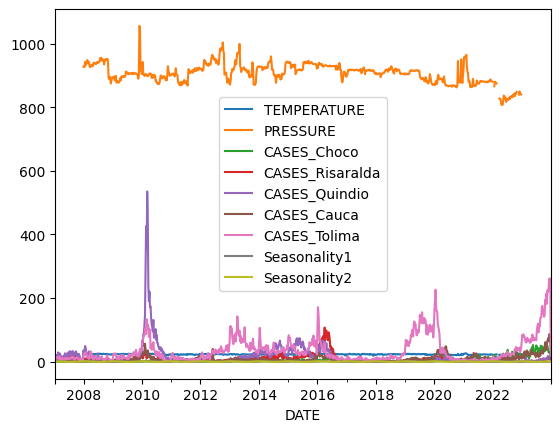

In [9]:
df_all.plot()

In [10]:
end_validation = f"{validation_year}-12-31"
df_cases = df_cases.loc[:end_validation, :]
df_temperature = df_temperature.loc[:end_validation, :]
df_pressure = df_pressure.loc[:end_validation, :]
df_spatial = df_spatial.loc[:end_validation, :]
df_seasonality = df_seasonality.loc[:end_validation, :]
df_all = df_all.loc[:end_validation, :]

In [11]:
# df_lags = df_all.copy()

# for col in df_all.columns.drop("CASES"):
#     for lag in lags:
#         df_lags[f"{col}_lag{lag}"] = df_all[col].shift(lag)

# df_lags = df_lags.dropna()

# Functions

In [12]:
def correlation_lags(df_target, df_series, lags):
    """
    Calcula y visualiza correlaciones entre una serie target y varias series con rezagos.

    Parameters:
    -----------
    df_target : pd.DataFrame o pd.Series
        Serie objetivo (ej: casos ciudad). Debe tener un índice temporal.
    df_series : pd.DataFrame
        DataFrame con n series explicativas (sin lags).
    lags : list
        Lista de enteros con los rezagos a considerar (ej: [1,2,3,4]).
    """
    
    # Asegurar que target sea serie
    if isinstance(df_target, pd.DataFrame):
        target = df_target.iloc[:,0]
    else:
        target = df_target

    corr_matrix = pd.DataFrame(index=df_series.columns, columns=lags, dtype=float)

    # Calcular correlaciones
    for col in df_series.columns:
        for lag in lags:
            shifted = df_series[col].shift(lag)
            corr_matrix.loc[col, lag] = target.corr(shifted)

    # Heatmap con escala fija [-1,1]
    plt.figure(figsize=(10, df_series.shape[1]*0.5+3))
    sns.heatmap(
        corr_matrix, annot=True, cmap="coolwarm", center=0,
        cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1
    )
    plt.title("Correlation heatmap: target vs. series with lags")
    plt.ylabel("Variables")
    plt.xlabel("Lags (weeks)")
    plt.show()

    # Ranking de correlaciones absolutas
    corr_flat = corr_matrix.stack().reset_index()
    corr_flat.columns = ["variable", "lag", "correlation"]
    corr_flat["abs_corr"] = corr_flat["correlation"].abs()
    corr_flat = corr_flat.sort_values("abs_corr", ascending=False)

    print("\n>>> Ranking variables-lags (ordenadas por correlación absoluta):\n")
    for _, row in corr_flat.iterrows():
        print(f"{row['variable']} - lag {row['lag']}: corr = {row['correlation']:.3f}")
    
    return corr_matrix

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

def feature_importance_lags(df_target, df_series, lags, max_features=20, heatmap=False, figsize=(10,6)):
    """
    Calcula feature importance usando RandomForest con variables rezagadas.

    Parameters:
    -----------
    df_target : pd.Series o pd.DataFrame
        Serie objetivo (ej: casos ciudad).
    df_series : pd.DataFrame
        DataFrame con series explicativas (sin lags).
    lags : list
        Lista de rezagos (ej: [1,2,3,4]).
    max_features : int
        Número máximo de features a mostrar en el barplot.
    heatmap : bool
        Si True, muestra heatmap (variables en filas, lags en columnas).
    figsize : tuple
        Tamaño del gráfico.
    """

    # Asegurar que target sea Serie
    if isinstance(df_target, pd.DataFrame):
        y = df_target.iloc[:,0]
    else:
        y = df_target

    # Crear dataset con lags
    df_lags = pd.DataFrame(index=df_series.index)
    for col in df_series.columns:
        for lag in lags:
            df_lags[f"{col} - lag {lag}"] = df_series[col].shift(lag)

    # Alinear con target (dropna por los lags)
    df_lags = df_lags.dropna()
    y_aligned = y.loc[df_lags.index]

    # Entrenar Random Forest
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(df_lags, y_aligned)

    # Predicciones in-sample
    y_pred = rf.predict(df_lags)

    # Métricas
    r2 = r2_score(y_aligned, y_pred)
    mae = mean_absolute_error(y_aligned, y_pred)
    mape = mean_absolute_percentage_error(y_aligned, y_pred)

    print("\n>>> Evaluación del modelo RandomForest:")
    print(f"R²   = {r2:.3f}")
    print(f"MAE  = {mae:.3f}")
    print(f"MAPE = {mape*100:.2f}%")

    # Importancias
    importances = pd.Series(rf.feature_importances_, index=df_lags.columns)
    importances_sorted = importances.sort_values(ascending=False)

    # Construir importance_matrix (como correlation_lags)
    imp_df = importances.reset_index()
    imp_df.columns = ["feature", "importance"]
    imp_df["variable"] = imp_df["feature"].apply(lambda x: x.split(" - lag ")[0])
    imp_df["lag"] = imp_df["feature"].apply(lambda x: int(x.split(" - lag ")[1]))
    importance_matrix = imp_df.pivot_table(index="variable", columns="lag", values="importance", fill_value=0)

    # Plot
    if heatmap:
        plt.figure(figsize=(10, len(importance_matrix)*0.5 + 3))
        sns.heatmap(
            importance_matrix, annot=True, cmap="coolwarm", center=0,
            cbar_kws={'label': 'Importance'}, vmin=0, vmax=importance_matrix.values.max()
        )
        plt.title("Feature Importance Heatmap (Random Forest)")
        plt.ylabel("Variables")
        plt.xlabel("Lags (weeks)")
        plt.show()
    else:
        plt.figure(figsize=figsize)
        sns.barplot(
            x=importances_sorted.head(max_features),
            y=importances_sorted.head(max_features).index,
            palette="coolwarm"
        )
        plt.title("Feature Importance (Random Forest)")
        plt.xlabel("Importance")
        plt.ylabel("Features")
        plt.show()

    # Print ranking
    print("\n>>> Ranking variables-lags (ordenadas por importancia):\n")
    for feature, imp in importances_sorted.items():
        print(f"{feature}: imp = {imp:.3f}")

    return importance_matrix, rf, df_lags

In [14]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def shap_importance_lags(rf, df_lags, max_display=20, heatmap=False):
    """
    Calcula explicabilidad con SHAP para un modelo RandomForest entrenado con variables laggeadas.
    Devuelve ranking y matriz variable × lag.
    
    Parameters
    ----------
    rf : modelo entrenado (ej: RandomForestRegressor)
    df_lags : pd.DataFrame
        DataFrame con features laggeadas (mismo usado para entrenar el modelo).
    max_display : int
        Número máximo de features a mostrar en los plots SHAP.
    heatmap : bool
        Si True, muestra matriz SHAP en formato heatmap.
    
    Returns
    -------
    shap_values : shap.Explanation
        Valores SHAP completos.
    shap_ranking : pd.Series
        Ranking de importancia media absoluta SHAP.
    shap_matrix : pd.DataFrame
        Matriz variable × lag con valores medios absolutos SHAP.
    """

    # SHAP values
    explainer = shap.Explainer(rf, df_lags)
    shap_values = explainer(df_lags)

    print("\n>>> Generando gráficos SHAP...")

    # Summary plot (beeswarm)
    shap.summary_plot(shap_values, df_lags, max_display=max_display)

    # Bar plot de importancias SHAP
    shap.summary_plot(shap_values, df_lags, plot_type="bar", max_display=max_display)

    # Ranking por contribución media absoluta
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    shap_ranking = pd.Series(mean_abs_shap, index=df_lags.columns).sort_values(ascending=False)

    print("\n>>> Ranking SHAP (ordenadas por contribución media absoluta):\n")
    for feat, val in shap_ranking.items():
        print(f"{feat}: shap = {val:.3f}")

    # Construir shap_matrix (variable × lag)
    imp_df = shap_ranking.reset_index()
    imp_df.columns = ["feature", "shap_importance"]
    imp_df["variable"] = imp_df["feature"].apply(lambda x: x.split(" - lag ")[0])
    imp_df["lag"] = imp_df["feature"].apply(lambda x: int(x.split(" - lag ")[1]))
    shap_matrix = imp_df.pivot_table(index="variable", columns="lag", values="shap_importance", fill_value=0)

    # Plot heatmap si se pide
    if heatmap:
        plt.figure(figsize=(10, len(shap_matrix)*0.5 + 3))
        sns.heatmap(
            shap_matrix, annot=True, cmap="coolwarm", center=0,
            cbar_kws={'label': 'Mean(|SHAP|) importance'}, vmin=0, vmax=shap_matrix.values.max()
        )
        plt.title("SHAP Importance Heatmap")
        plt.ylabel("Variables")
        plt.xlabel("Lags (weeks)")
        plt.show()

    return shap_values, shap_ranking, shap_matrix

In [15]:
def combined_feature_ranking(corr_matrix, imp_matrix, shap_matrix, top_n=20, figsize=(10,6)):
    """
    Normaliza corr_matrix, imp_matrix y shap_matrix y calcula un ranking combinado.
    
    Parameters
    ----------
    corr_matrix : pd.DataFrame
        Matriz de correlación (variables x lags).
    imp_matrix : pd.DataFrame
        Matriz de importancia RandomForest (variables x lags).
    shap_matrix : pd.DataFrame
        Matriz de importancia SHAP (variables x lags).
    top_n : int
        Número máximo de features a mostrar en el barplot.
    figsize : tuple
        Tamaño del gráfico del barplot.
    
    Returns
    -------
    ranking_df : pd.DataFrame
        DataFrame con variable, lag y score total ordenado de mayor a menor.
    combined : pd.DataFrame
        Matriz combinada (variables x lags).
    """
    
    # --- 1. Normalización ---
    corr_norm = corr_matrix.abs()
    corr_norm = corr_norm / corr_norm.to_numpy().max()
    imp_norm = imp_matrix / imp_matrix.to_numpy().max()
    shap_norm = shap_matrix / shap_matrix.to_numpy().max()
    
    # --- 2. Asegurar mismas dimensiones ---
    common_index = corr_norm.index.intersection(imp_norm.index).intersection(shap_norm.index)
    common_cols = corr_norm.columns.intersection(imp_norm.columns).intersection(shap_norm.columns)
    
    corr_norm = corr_norm.loc[common_index, common_cols]
    imp_norm = imp_norm.loc[common_index, common_cols]
    shap_norm = shap_norm.loc[common_index, common_cols]
    
    # --- 3. Suma combinada ---
    combined = corr_norm + imp_norm + shap_norm
    
    # --- 4. Convertir a formato largo ---
    ranking_df = combined.stack().reset_index()
    ranking_df.columns = ["variable", "lag", "score"]
    ranking_df = ranking_df.sort_values("score", ascending=False).reset_index(drop=True)

    # --- 6. Barplot con Top N ---
    top_df = ranking_df.head(top_n).copy()
    top_df["feat"] = top_df["variable"] + " - lag " + top_df["lag"].astype(str)

    plt.figure(figsize=figsize)
    sns.barplot(x="score", y="feat", data=top_df, palette="coolwarm")
    plt.title(f"Top {top_n} Combined Feature Importance")
    plt.xlabel("Score (normalized sum)")
    plt.ylabel("Feature (variable - lag)")
    plt.show()

    # --- 5. Print ranking ---
    print("\n>>> Ranking combinado (normalizado y sumado):\n")
    for _, row in ranking_df.iterrows():
        print(f"{row['variable']} - lag {row['lag']}: score = {row['score']:.3f}")
    
    return ranking_df, combined

In [16]:
def plot_combined_matrix(combined, figsize=(10,6)):
    """
    Plotea la matriz combinada de scores (correlación + importancia RF + SHAP) como heatmap.
    
    Parameters
    ----------
    combined : pd.DataFrame
        Matriz combinada (variables x lags).
    figsize : tuple
        Tamaño del gráfico.
    """
    
    plt.figure(figsize=(10, len(combined)*0.5 + 3))
    sns.heatmap(
        combined, annot=True, cmap="coolwarm", center=0,
        cbar_kws={'label': 'Combined score'}, vmin=0, vmax=combined.values.max()
    )
    plt.title("Combined Feature Importance (Correlation + RF + SHAP)")
    plt.ylabel("Variables")
    plt.xlabel("Lags")
    plt.show()

# Feature selection

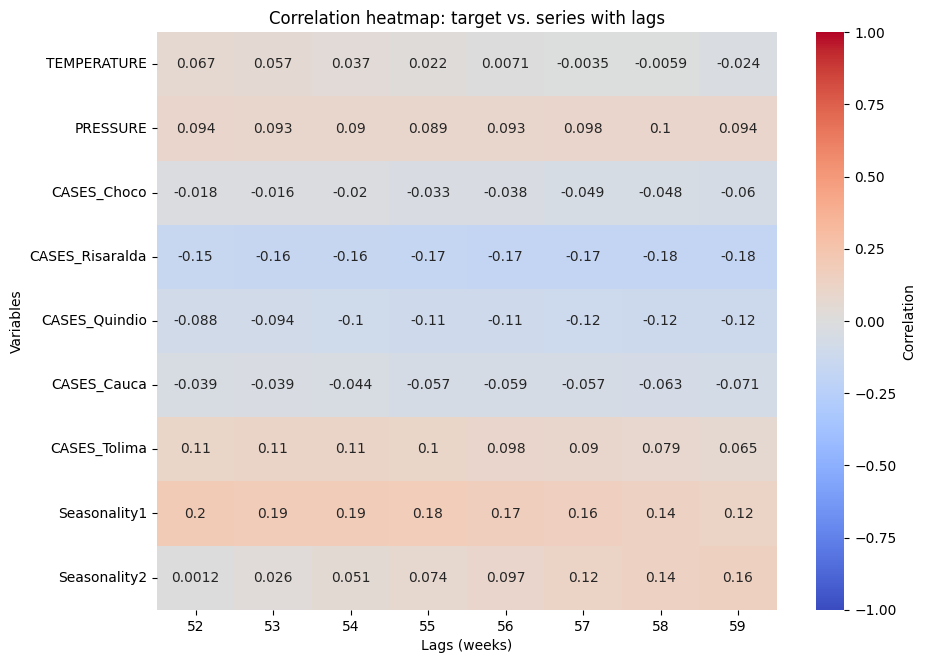


>>> Ranking variables-lags (ordenadas por correlación absoluta):

Seasonality1 - lag 52: corr = 0.195
Seasonality1 - lag 53: corr = 0.194
Seasonality1 - lag 54: corr = 0.189
Seasonality1 - lag 55: corr = 0.181
CASES_Risaralda - lag 58: corr = -0.177
CASES_Risaralda - lag 59: corr = -0.176
CASES_Risaralda - lag 57: corr = -0.174
CASES_Risaralda - lag 56: corr = -0.173
Seasonality1 - lag 56: corr = 0.171
CASES_Risaralda - lag 55: corr = -0.169
CASES_Risaralda - lag 54: corr = -0.163
CASES_Risaralda - lag 53: corr = -0.159
Seasonality1 - lag 57: corr = 0.158
Seasonality2 - lag 59: corr = 0.156
CASES_Risaralda - lag 52: corr = -0.153
Seasonality1 - lag 58: corr = 0.142
Seasonality2 - lag 58: corr = 0.138
Seasonality1 - lag 59: corr = 0.124
CASES_Quindio - lag 59: corr = -0.124
CASES_Quindio - lag 58: corr = -0.121
Seasonality2 - lag 57: corr = 0.118
CASES_Quindio - lag 57: corr = -0.116
CASES_Tolima - lag 53: corr = 0.113
CASES_Tolima - lag 54: corr = 0.112
CASES_Quindio - lag 56: corr = 

In [17]:
correlation_matrix = correlation_lags(df_cases, df_all, lags=lags)


>>> Evaluación del modelo RandomForest:
R²   = 0.942
MAE  = 19.144
MAPE = 43.81%


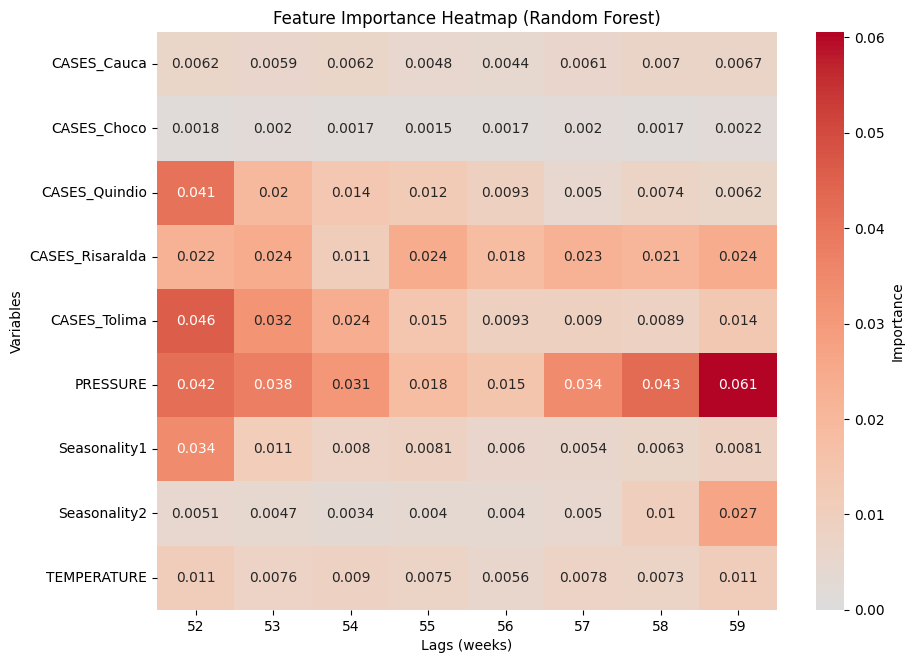


>>> Ranking variables-lags (ordenadas por importancia):

PRESSURE - lag 59: imp = 0.061
CASES_Tolima - lag 52: imp = 0.046
PRESSURE - lag 58: imp = 0.043
PRESSURE - lag 52: imp = 0.042
CASES_Quindio - lag 52: imp = 0.041
PRESSURE - lag 53: imp = 0.038
Seasonality1 - lag 52: imp = 0.034
PRESSURE - lag 57: imp = 0.034
CASES_Tolima - lag 53: imp = 0.032
PRESSURE - lag 54: imp = 0.031
Seasonality2 - lag 59: imp = 0.027
CASES_Risaralda - lag 59: imp = 0.024
CASES_Risaralda - lag 53: imp = 0.024
CASES_Risaralda - lag 55: imp = 0.024
CASES_Tolima - lag 54: imp = 0.024
CASES_Risaralda - lag 57: imp = 0.023
CASES_Risaralda - lag 52: imp = 0.022
CASES_Risaralda - lag 58: imp = 0.021
CASES_Quindio - lag 53: imp = 0.020
PRESSURE - lag 55: imp = 0.018
CASES_Risaralda - lag 56: imp = 0.018
PRESSURE - lag 56: imp = 0.015
CASES_Tolima - lag 55: imp = 0.015
CASES_Quindio - lag 54: imp = 0.014
CASES_Tolima - lag 59: imp = 0.014
CASES_Quindio - lag 55: imp = 0.012
Seasonality1 - lag 53: imp = 0.011
CASE

In [18]:
importance_matrix, rf, df_lags = feature_importance_lags(
    df_cases, df_all, lags=lags, heatmap=True
)

 97%|=================== | 553/568 [00:28<00:00]       


>>> Generando gráficos SHAP...


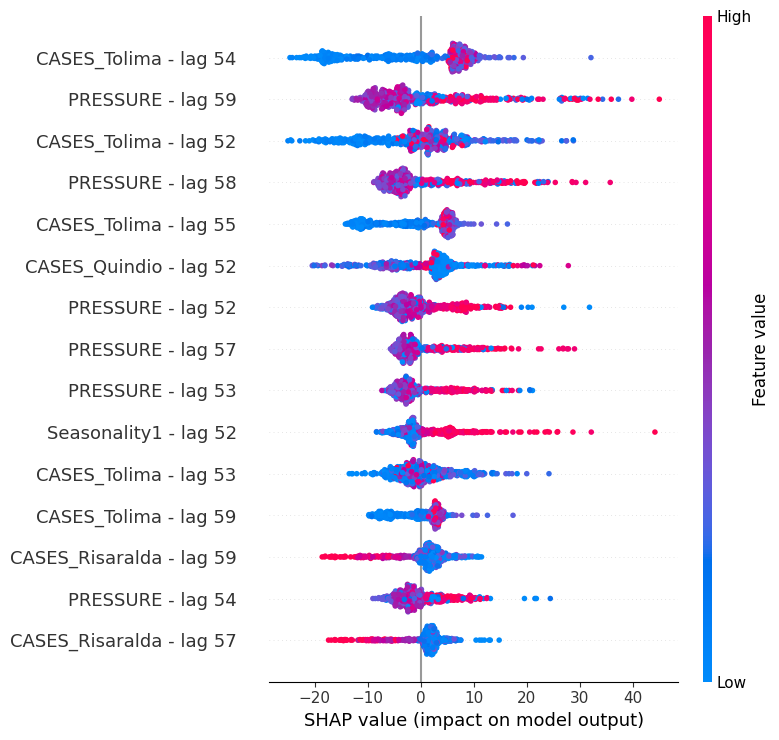

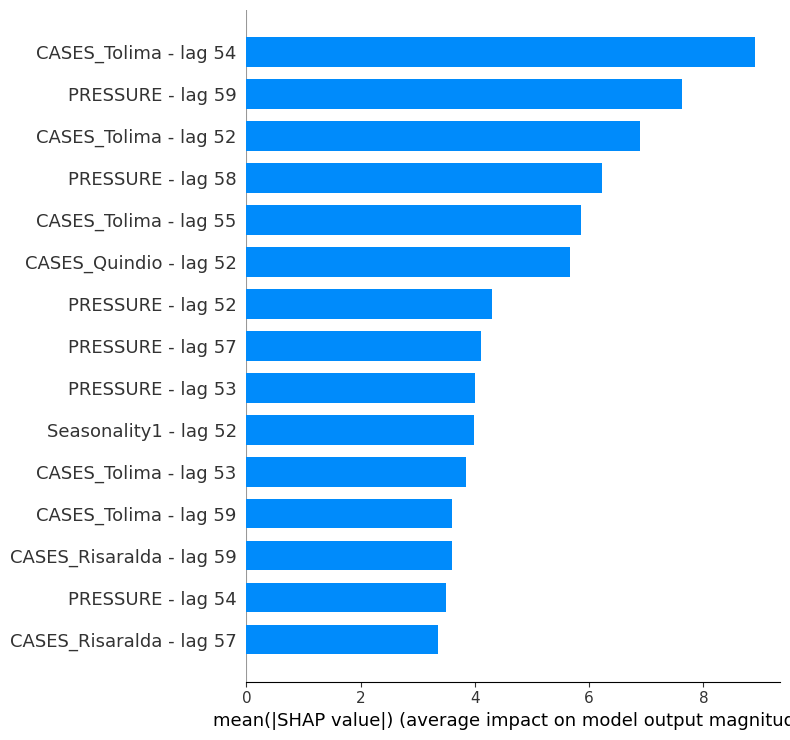


>>> Ranking SHAP (ordenadas por contribución media absoluta):

CASES_Tolima - lag 54: shap = 8.896
PRESSURE - lag 59: shap = 7.626
CASES_Tolima - lag 52: shap = 6.885
PRESSURE - lag 58: shap = 6.222
CASES_Tolima - lag 55: shap = 5.861
CASES_Quindio - lag 52: shap = 5.671
PRESSURE - lag 52: shap = 4.303
PRESSURE - lag 57: shap = 4.115
PRESSURE - lag 53: shap = 3.997
Seasonality1 - lag 52: shap = 3.987
CASES_Tolima - lag 53: shap = 3.848
CASES_Tolima - lag 59: shap = 3.600
CASES_Risaralda - lag 59: shap = 3.598
PRESSURE - lag 54: shap = 3.495
CASES_Risaralda - lag 57: shap = 3.348
CASES_Risaralda - lag 55: shap = 3.140
CASES_Tolima - lag 57: shap = 3.064
CASES_Tolima - lag 56: shap = 2.999
Seasonality2 - lag 59: shap = 2.462
CASES_Risaralda - lag 58: shap = 2.419
CASES_Risaralda - lag 53: shap = 2.409
CASES_Quindio - lag 53: shap = 2.367
PRESSURE - lag 55: shap = 2.351
CASES_Tolima - lag 58: shap = 2.342
CASES_Risaralda - lag 56: shap = 2.208
PRESSURE - lag 56: shap = 1.920
CASES_Risara

In [19]:
shap_values, shap_ranking, shap_matrix = shap_importance_lags(rf, df_lags, max_display=15)

/tmp/ipykernel_405268/1489518426.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="score", y="feat", data=top_df, palette="coolwarm")


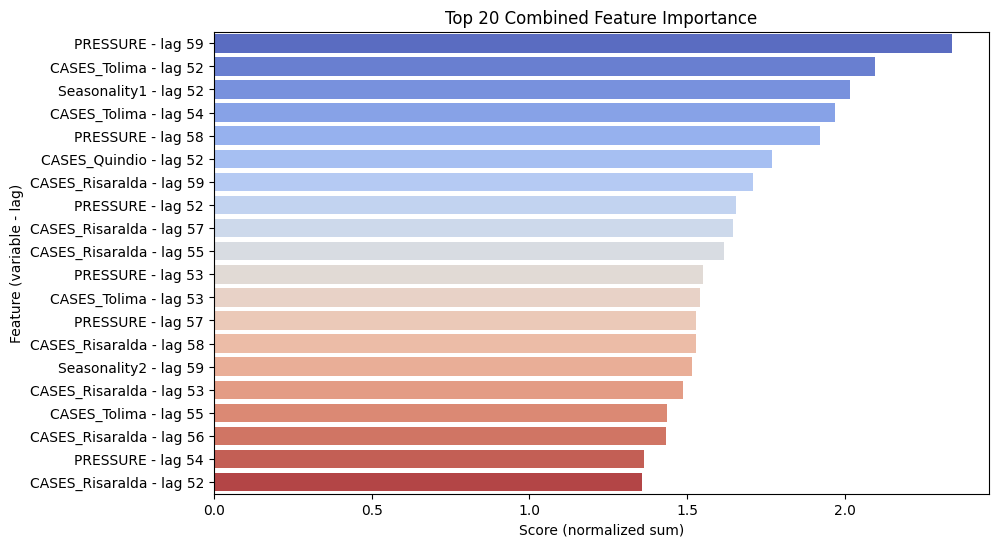


>>> Ranking combinado (normalizado y sumado):

PRESSURE - lag 59: score = 2.338
CASES_Tolima - lag 52: score = 2.096
Seasonality1 - lag 52: score = 2.017
CASES_Tolima - lag 54: score = 1.970
PRESSURE - lag 58: score = 1.920
CASES_Quindio - lag 52: score = 1.769
CASES_Risaralda - lag 59: score = 1.710
PRESSURE - lag 52: score = 1.654
CASES_Risaralda - lag 57: score = 1.644
CASES_Risaralda - lag 55: score = 1.617
PRESSURE - lag 53: score = 1.550
CASES_Tolima - lag 53: score = 1.541
PRESSURE - lag 57: score = 1.529
CASES_Risaralda - lag 58: score = 1.527
Seasonality2 - lag 59: score = 1.514
CASES_Risaralda - lag 53: score = 1.487
CASES_Tolima - lag 55: score = 1.437
CASES_Risaralda - lag 56: score = 1.432
PRESSURE - lag 54: score = 1.365
CASES_Risaralda - lag 52: score = 1.358
Seasonality1 - lag 53: score = 1.322
CASES_Risaralda - lag 54: score = 1.174
Seasonality1 - lag 54: score = 1.166
Seasonality1 - lag 55: score = 1.165
CASES_Quindio - lag 53: score = 1.068
Seasonality1 - lag 56: sc

In [20]:
ranking_df, combined = combined_feature_ranking(correlation_matrix, importance_matrix, shap_matrix)

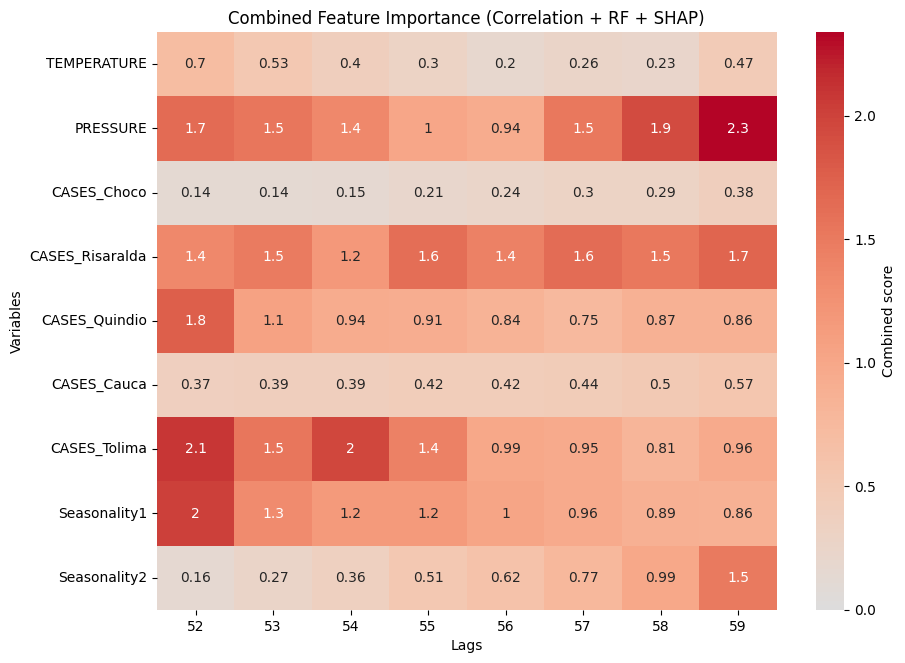

In [21]:
# Plot como heatmap
plot_combined_matrix(combined)

# Test

In [22]:
import pandas as pd

def max_valid_lags(last_date, first_forecast_date, freq="W"):
    """
    Calcula el número máximo de lags válidos según la frecuencia temporal
    de los datos (por defecto semanal, freq="W").
    
    Parameters
    ----------
    last_date : str o pd.Timestamp
        Última fecha de observación (ej: '2023-12-31').
    first_forecast_date : str o pd.Timestamp
        Primera fecha a predecir (ej: '2026-01-04').
    freq : str
        Frecuencia de los datos. Default "W" (semanal).
    
    Returns
    -------
    max_lags : int
        Número máximo de lags (en pasos de la frecuencia) que puedes usar
        sin quedarte sin datos al inicio del forecast.
    """
    
    last_date = pd.to_datetime(last_date)
    first_forecast_date = pd.to_datetime(first_forecast_date)

    # Generamos rango con la frecuencia dada
    weeks = pd.date_range(start=last_date, end=first_forecast_date, freq=freq)

    # El número de pasos entre ambas fechas
    steps_gap = len(weeks) - 1

    print(f"Última fecha de datos: {last_date.date()}")
    print(f"Primera fecha de forecast: {first_forecast_date.date()}")
    print(f"Gap en '{freq}': {steps_gap}")

    print(f"\n>>> Máximo lag válido: {steps_gap}")
    return steps_gap


In [23]:
max_valid_lags("2023-12-31", "2025-06-04", freq="W")

Última fecha de datos: 2023-12-31
Primera fecha de forecast: 2026-01-04
Gap en 'W': 105

>>> Máximo lag válido: 105


105

In [24]:
# # Pruebas de causalidad de Granger
# def granger_causality(series1, series2, maxlag):
#     print("\n>>> Pruebas de causalidad de Granger (p-values < 0.05 sugieren poder predictivo):\n")
#     for neigh in df_spatial.columns:
#         print(f"\n--- Granger causality test for {neigh} ---")
#         grangercausalitytests(df_all[["CASES", neigh]], maxlag=4, verbose=True)